In [19]:
import os
os.environ["PYTORCH_LIGHTNING_SUPPRESS_WARNINGS"] = "true"
import logging
import pytorch_lightning as pl

# Silence Lightning logging
pl_logger = logging.getLogger("pytorch_lightning")
pl_logger.setLevel(logging.ERROR)


In [20]:
import numpy as np
import pytorch_lightning as pl
import torch


def get_prediction(data, model: pl.LightningModule, device):
    model.eval() # Deactivates gradient graph construction during eval.
    data = data.to(device)
    model.to(device)
    probabilities = torch.softmax(model(data), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities


def get_true_targets_predictions(test_dl, model, device):
    true_targets, predictions = [], []
    for batch in iter(test_dl):
        data, target = batch
        true_targets.extend(target)
        prediction, _ = get_prediction(data, model, device)
        predictions.extend(prediction.cpu())
    return true_targets, predictions


def get_eval_loss(test_dl, model, device):
    model.eval()
    loss = 0
    for n, batch in enumerate(test_dl):
        data, target = batch
        logits = model(data.to(device))
        loss += model.loss(logits, target.to(device))
    return loss / n


def generate_fbm(N, H):
    '''
    Generates sample paths of fractional Brownian Motion using the Davies Harte method

    args:
        N:      number of time steps within timeframe
        H:      Hurst parameter
    '''
    gamma = lambda k, H: 0.5 * (
                np.abs(k - 1) ** (2 * H) - 2 * np.abs(k) ** (2 * H) + np.abs(
            k + 1) ** (2 * H))
    g = [gamma(k, H) for k in range(0, N)]
    r = g + [0] + g[::-1][0:N - 1]

    # Step 1 (eigenvalues)
    j = np.arange(0, 2 * N)
    k = 2 * N - 1
    lk = np.fft.fft(
        r * np.exp(2 * np.pi * complex(0, 1) * k * j * (1 / (2 * N))))[::-1]

    # Step 2 (get random variables)
    Vj = np.zeros((2 * N, 2), dtype=complex)
    Vj[0, 0] = np.random.standard_normal()
    Vj[N, 0] = np.random.standard_normal()

    for i in range(1, N):
        Vj1 = np.random.standard_normal()
        Vj2 = np.random.standard_normal()
        Vj[i][0] = Vj1
        Vj[i][1] = Vj2
        Vj[2 * N - i][0] = Vj1
        Vj[2 * N - i][1] = Vj2

    # Step 3 (compute Z)
    wk = np.zeros(2 * N, dtype=complex)
    wk[0] = np.sqrt((lk[0] / (2 * N))) * Vj[0][0]
    wk[1:N] = np.sqrt(lk[1:N] / (4 * N)) * (
                (Vj[1:N].T[0]) + (complex(0, 1) * Vj[1:N].T[1]))
    wk[N] = np.sqrt((lk[0] / (2 * N))) * Vj[N][0]
    wk[N + 1:2 * N] = np.sqrt(lk[N + 1:2 * N] / (4 * N)) * (
                np.flip(Vj[1:N].T[0]) - (
                    complex(0, 1) * np.flip(Vj[1:N].T[1])))

    Z = np.fft.fft(wk)
    fGn = Z[0:N]
    fBm = np.cumsum(fGn) * (N ** (-H))
    path = np.array([0] + list(fBm))
    return path, fGn


def rbf_kernel(x1, x2, variance):
    return np.exp(-1 * ((x1-x2) ** 2) / (2*variance))


def gram_matrix(depth, variance):
    xs = np.linspace(0, 1, depth + 1)
    return [[rbf_kernel(x1, x2, variance) for x2 in xs] for x1 in xs]

In [21]:
from abc import ABC, abstractmethod

import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn


def create_linear_layers_rbf(depth: int, width: int, regularity: float) -> nn.Sequential:
    mean = [0] * (depth + 1)
    gram = gram_matrix(depth, regularity)
    gp = np.random.default_rng().multivariate_normal(mean, gram, (width, width))
    increments = gp[:, :, 1:] - gp[:, :, :-1]
    weights = torch.Tensor(increments / (np.mean(np.std(increments, axis=(0, 1))) * np.sqrt(width)))
    layers = [nn.Linear(width, width, bias=False) for _ in range(depth)]
    for k in range(depth):
        layers[k].weight = torch.nn.Parameter(weights[:, :, k])
    return nn.Sequential(*layers)


def create_linear_layers_fbm(depth: int, width: int, hurst_index: float) -> nn.Sequential:
    weights = torch.zeros(depth, width, width)
    for i in range(width):
        for j in range(width):
            weights[:, i, j] = torch.Tensor(generate_fbm(depth, hurst_index)[1] / np.sqrt(width))
    layers = [nn.Linear(width, width) for _ in range(depth)]
    for k in range(depth):
        layers[k].weight = torch.nn.Parameter(weights[k])
        layers[k].bias = torch.nn.Parameter(torch.zeros(width,))
    return nn.Sequential(*layers)


def create_linear_layer(in_features: int, out_features: int, bias: bool = True) -> nn.Linear:
    layer = nn.Linear(in_features, out_features, bias=bias)
    length = torch.sqrt(torch.Tensor([3. / in_features]))
    layer.weight = nn.Parameter(2 * length * torch.rand((out_features, in_features)) - length)
    if bias:
        layer.bias = nn.Parameter(2 * length * torch.rand((out_features,)) - length)
    return layer


class ResNet(pl.LightningModule, ABC):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        super().__init__()
        self.initial_width = first_coord
        self.final_width = final_width
        self.model_config = model_config
        self.width = model_config['width']
        self.depth = model_config['depth']
        self.activation = getattr(nn, model_config['activation'])()

        self.scaling_weight = torch.full((self.depth,), 1 / (float(self.depth) ** model_config['scaling']))
        self.init = create_linear_layer(self.initial_width, self.width, bias=False)
        self.final = create_linear_layer(self.width, self.final_width, bias=False)
        self.loss = nn.CrossEntropyLoss()
        self.loss_history = []

    def reset_scaling(self, scaling: float):
        self.scaling_weight = torch.full((self.depth,), 1 / (float(self.depth) ** scaling))

    @abstractmethod
    def forward_hidden_state(self, hidden_state):
        ...

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hidden_state = self.init(x)
        hidden_state = self.forward_hidden_state(hidden_state)
        return self.final(hidden_state)

    def training_step(self, batch, batch_no):
        self.train()
        data, target = batch
        logits = self(data)
        loss = self.loss(logits, target)
        self.loss_history.append(loss.item())  # Track loss
        self.log("train/loss", loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.model_config['lr'])


class SimpleResNet(ResNet):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        super().__init__(first_coord, final_width, **model_config)

        if model_config['regularity']['type'] == 'iid':
            self.outer_weights = nn.Sequential(
                *[create_linear_layer(self.width, self.width, bias=False) for _ in range(self.depth)])
        elif model_config['regularity']['type'] == 'fbm':
            self.outer_weights = create_linear_layers_fbm(self.depth, self.width, model_config['regularity']['value'])
        elif model_config['regularity']['type'] == 'rbf':
            self.outer_weights = create_linear_layers_rbf(self.depth, self.width, model_config['regularity']['value'])
        else:
            raise ValueError("argument regularity['type'] should be one of 'iid', 'fbm', 'rbf'")

    def forward_hidden_state(self, hidden_state: torch.Tensor) -> torch.Tensor:
        for k in range(self.depth):
            pre_activation = hidden_state
            activated = self.activation(pre_activation)
            hidden_state = hidden_state + (
                self.scaling_weight[k] * self.outer_weights[k](activated)
            ) 
        return hidden_state


class FullResNet(ResNet):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        super().__init__(first_coord, final_width, **model_config)

        if model_config['regularity']['type'] == 'iid':
            self.inner_weights = nn.Sequential(
                *[create_linear_layer(self.width, self.width, bias=False) for _ in range(self.depth)])
            self.outer_weights = nn.Sequential(
                *[create_linear_layer(self.width, self.width, bias=False) for _ in range(self.depth)])
        elif model_config['regularity']['type'] == 'fbm':
            self.inner_weights = create_linear_layers_fbm(self.depth, self.width, model_config['regularity']['value'])
            self.outer_weights = create_linear_layers_fbm(self.depth, self.width, model_config['regularity']['value'])
        elif model_config['regularity']['type'] == 'rbf':
            self.inner_weights = create_linear_layers_rbf(self.depth, self.width, model_config['regularity']['value'])
            self.outer_weights = create_linear_layers_rbf(self.depth, self.width, model_config['regularity']['value'])
        else:
            raise ValueError("argument regularity['type'] should be one of 'iid', 'fbm', 'rbf'")

        self.final = create_linear_layer(self.width, self.final_width, bias=False)
        self.loss = nn.CrossEntropyLoss()

    def forward_hidden_state(self, hidden_state: torch.Tensor) -> torch.Tensor:
        for k in range(self.depth):
            pre_activation = self.inner_weights[k](hidden_state)
            activated = self.activation(pre_activation)
            hidden_state = hidden_state + (
                self.scaling_weight[k] * self.outer_weights[k](activated)
            ) 
            #+ ch_scale * correction_term
        return hidden_state


In [22]:

scaling_initialization_exp_iid = {
    'name': 'scaling_initialization_exp',
    'model': 'FullResNet',
    'use_correction': True,
    'model-config': {
        'width': 10,
        'activation': 'Tanh',
        'regularity': {'type': 'iid'}
    },
    'niter': 50,
    'dim_input': 64,
    'nb_classes': 1,
}

scaling_initialization_exp_smooth = {
    'name': 'scaling_initialization_exp',
    'model': 'FullResNet',
    'use_correction': True,
    'model-config': {
        'width': 10,
        'activation': 'Tanh',
        'regularity': {
            'type': 'rbf',
            'value': 0.01
        }
    },
    'niter': 50,
    'dim_input': 64,
    'nb_classes': 1,
}

histogram_initialization_exp = {
    'name': 'histogram_initialization_exp',
    'model': 'FullResNet',
    'use_correction': True,
    'model-config': {
        'width': 10,
        'depth': 10**3,
        'scaling': 0.5,
        'activation': 'Tanh',
        'regularity': {'type': 'iid'}
    },
    'niter': 10 ** 2,
    'dim_input': 64,
    'nb_classes': 1,
}

scaling_regularity_initialization_exp = {
    'name': 'scaling_regularity_initialization_exp',
    'model': 'FullResNet',
    'use_correction': True,
    'model-config': {
        'width': 10,
        'depth': 100,
        'scaling': 0.5,
        'activation': 'Tanh',
        'regularity': {}
    },
    'niter_reg': 5,
    'niter_scaling': 10,
    'dim_input': 64,
    'nb_classes': 1,
}

weights_after_training = {
    'name': 'weights-after-training',
    'model': 'FullResNet',
    'dataset': 'MNIST',
    'use_correction': True,
    'model-config': {
        'width': 10,
        'depth': 100,
        'activation': 'Tanh',              # 'ReLU' or 'Tanh'
        'lr': 0.01,
        'step_lr': 1000
    },
    'epochs': 100,
    'n_workers': 10
}

perf_weights_regularity = {
    'name': 'perf-weights-regularity-dataset',
    'model': 'FullResNet',
    'dataset': 'MNIST',
    'use_correction': True,
    'model-config': {
        'width': 10,
        'depth': 100,
        'activation': 'Tanh',              # 'ReLU' or 'Tanh'
        'scaling': 1.,
        'regularity':
            {
                'type': 'fbm',
                'value': 0.5
            },
        'lr': 0.001,
        'step_lr': 5
    },
    'epochs': 1,
    'n_workers': 10
}

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


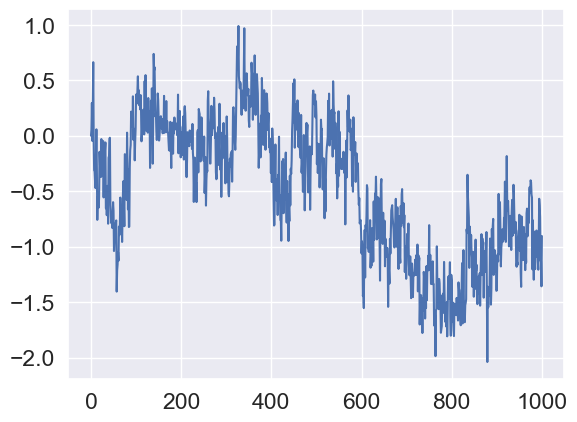

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


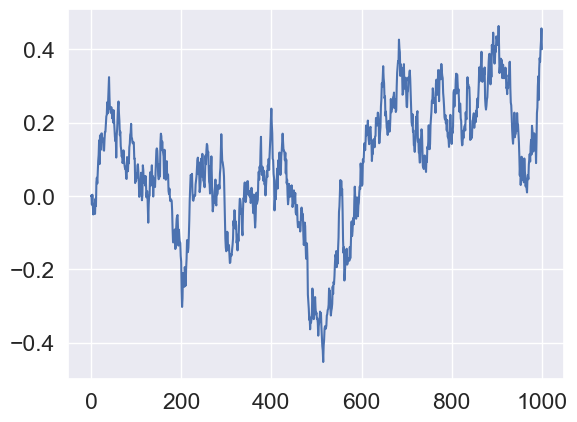

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


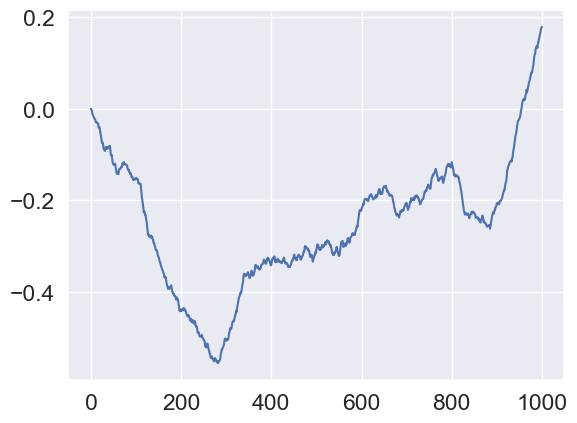

0.05
0.0684
0.0868
0.1052
0.1236
0.14200000000000002
0.1604
0.17880000000000001
0.1972
0.2156
0.23399999999999999
0.2524
0.2708
0.2892
0.3076
0.326
0.3444
0.36279999999999996
0.3812
0.3996
0.418
0.43639999999999995
0.4548
0.4732
0.4916
0.51
0.5284
0.5468000000000001
0.5652
0.5836
0.6020000000000001
0.6204000000000001
0.6388
0.6572
0.6756
0.6940000000000001
0.7124
0.7308
0.7492000000000001
0.7676000000000001
0.786
0.8044
0.8228
0.8412000000000001
0.8596
0.878
0.8964000000000001
0.9148000000000001
0.9332
0.9516
0.97


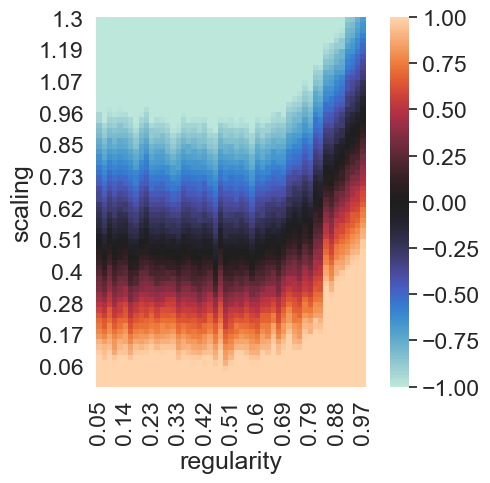

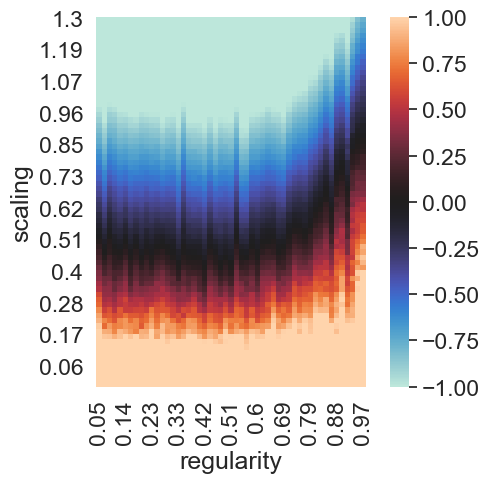

In [23]:
import distutils.spawn
import os
from typing import Optional

from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

sns.set(font_scale=1.5)

if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)


def run_experiment(config: dict, grid_scaling: list, grid_reg: list) -> list:
    """ Loop over a grid of initializations and scaling values, compute ratios
    between norms of the output and the input, as well as their respective
    gradients.

    :param config: configuration of the experiment
    :param grid_scaling: all values of scaling to loop over
    :param grid_reg: regularity of the process used to initialize the weights
    of the network
    :return:
    """

    results = []
    for reg in grid_reg:
        print(reg)
        for k in range(config['niter_reg']):
            model_config = config['model-config']
            model_config['regularity']['type'] = 'fbm'
            model_config['regularity']['value'] = reg
            model = FullResNet(
                config['dim_input'], config['nb_classes'], **model_config)

            for scaling in grid_scaling:
                model.reset_scaling(scaling)
                for j in range(config['niter_scaling']):

                    x0 = torch.rand((1, config['dim_input']))
                    target = torch.rand((1,))

                    h_0 = model.init(x0)
                    h_L = model.forward_hidden_state(h_0)
                    output = model.final(h_L)

                    h_0.retain_grad()
                    h_L.retain_grad()

                    loss = torch.norm(output - target) ** 2
                    loss.backward()

                    h_0_grad = h_0.grad
                    h_L_grad = h_L.grad

                    results.append({
                        'scaling': scaling,
                        'regularity': reg,
                        'hidden_state_difference': float(
                            torch.norm(h_L - h_0) / torch.norm(h_0)),
                        'gradient_difference': float(
                            torch.norm(h_L_grad - h_0_grad) / torch.norm(
                                h_L_grad)),
                        })
    return results


def plot_results(results: list, filepath: Optional[str] = 'figures'):
    """Plot heatmaps which describes the hidden state and gradient norms,
    as a function of scaling and initialization regularity.
    See Figure 7 of the paper.

    :param results: list of results
    :param filepath: path to the folder where the figures should be saved
    :return:
    """
    df = pd.DataFrame(results)
    df.columns = ['scaling', 'regularity', 'hidden_state_difference',
                  'gradient_difference']
    df['log_hidden_state_difference'] = np.log10(df['hidden_state_difference'])
    df['log_gradients_difference'] = np.log10(df['gradient_difference'])

    df1 = df.pivot_table(index='scaling', columns='regularity',
                         values='log_hidden_state_difference', dropna=False)
    df1.index = np.round(df1.index.astype(float), 2)
    df1.columns = np.round(df1.columns.astype(float), 2)
    df1.replace(np.inf, np.nan, inplace=True)
    df1.fillna(16, inplace=True)
    sns.heatmap(df1[::-1], vmin=-1, vmax=1, center=0, xticklabels=5,
                yticklabels=6, square=True)
    plt.savefig(
        os.path.join(filepath, 'heatmap-scaling-regularity-output.pdf'),
        bbox_inches='tight')
    plt.show()

    df2 = df.pivot_table(index='scaling', columns='regularity',
                         values='log_gradients_difference', dropna=False)
    df2.index = np.round(df2.index.astype(float), 2)
    df2.columns = np.round(df2.columns.astype(float), 2)
    df2.replace(np.inf, np.nan, inplace=True)
    df2.fillna(16, inplace=True)
    sns.heatmap(df2[::-1], vmin=-1, vmax=1, center=0, xticklabels=5,
                yticklabels=6, square=True)
    plt.savefig(
        os.path.join(filepath, 'heatmap-scaling-regularity-gradient.pdf'),
        bbox_inches='tight')
    plt.show()


if __name__ == '__main__':

    # Plot examples of fractional Brownian Motion - Figure 6 of the paper
    grid_H = [0.2, 0.5, 0.8]
    filepath = 'figures/regularity_and_scaling_initialization'
    os.makedirs(filepath, exist_ok=True)
    for hurst in grid_H:
        path = generate_fbm(1000, hurst)[0]
        plt.plot(path)
        plt.savefig(
            os.path.join(filepath, 'fbm_examples-{:.1f}.pdf'.format(hurst)),
            bbox_inches='tight')
        plt.show()

    # Run the experiments to loop over various initializations and scalings
    # Figure 7 of the paper
    config_heatmap = scaling_regularity_initialization_exp

    grid_scaling = list(np.linspace(0, 1.3, 70))
    grid_reg = list(np.linspace(0.05, 0.97, 51))

    results = run_experiment(config_heatmap, grid_scaling, grid_reg)
    plot_results(results, filepath)

In [24]:
import os

import numpy as np
import torchvision.datasets
import torchvision.transforms as transforms
import torch.utils.data


# This is useful to reshape 2d image tensors into a 1d-tensor.
# See https://discuss.pytorch.org/t/missing-reshape-in-torchvision/9452/7
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size
    def __call__(self, img):
        return torch.reshape(img, self.new_size)


def load_dataset(name, vectorize):
    if vectorize:
        transform_img_to_vect = transforms.Compose([transforms.ToTensor(), ReshapeTransform((-1,))])
    else:
        transform_img_to_vect = transforms.Compose([transforms.ToTensor()])
    try:
        dataset_class = getattr(torchvision.datasets, name)
    except AttributeError:
        raise ValueError('%s is not a torchvision dataset.' % name)
    train_arg = {'split': 'train'} if name == 'SVHN' else {'train': True}
    test_arg = {'split': 'test'} if name == 'SVHN' else {'train': False}
    train_ds = dataset_class(
        os.path.join("datasets", name), download=True, transform=transform_img_to_vect, **train_arg)
    test_ds = dataset_class(
        os.path.join("datasets", name), download=True, transform=transform_img_to_vect, **test_arg)
    train_dl = torch.utils.data.DataLoader(
        train_ds, batch_size=128, shuffle=True, pin_memory=True)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, pin_memory=True)
    if vectorize:
        first_coord = np.prod(np.array(train_ds.data[0].shape))
    elif len(train_ds.data[0].shape) == 2: # Black and white image, so only one channel.
        first_coord = 1
    else:
        first_coord = train_ds.data[0].shape[0]
    nb_classes = len(np.unique(train_ds.labels)) if name == 'SVHN' else len(train_ds.classes)
    return train_dl, test_dl, first_coord, nb_classes

In [25]:
import copy
import glob
from multiprocessing import Pool
import os
import pickle
import time
from typing import Optional

import numpy as np
import pytorch_lightning as pl
import torch



def get_results(exp_name: str) -> list:
    """Read the results saved after execution of the training file.

    :param exp_name: name of the configuration
    :return: list of results
    """
    results = {'accuracy': [], 'regularity': [], 'lr': [], 'scaling': []}
    for directory in glob.glob(os.path.join('results', exp_name, '*')):
        with open(os.path.join(directory, 'config.pkl'), 'rb') as f:
            config = pickle.load(f)
            results['regularity'].append(
                config['model-config']['regularity']['value'])
            results['lr'].append(config['model-config']['lr'])
            results['scaling'].append(config['model-config']['scaling'])
        with open(os.path.join(directory, 'metrics.pkl'), 'rb') as f:
            metrics = pickle.load(f)
            results['accuracy'].append(metrics['test_accuracy'])

    return results


def fit(config_dict: dict, verbose: bool = False) -> pl.LightningModule:
    """Train a ResNet following the configuration.

    :param config_dict: configuration of the network and dataset
    :param verbose: print information about traning
    :return: the trained model
    """
    name = config_dict['name'].replace('dataset', config_dict['dataset'])

    train_dl, test_dl, first_coord, nb_classes = load_dataset(
        config_dict['dataset'], vectorize=True)

    model_class = globals()[config_dict['model']]
    model = model_class(
        first_coord=first_coord, final_width=nb_classes,
        **config_dict['model-config'])

    gpu = 1 if torch.cuda.is_available() else 0
    device = torch.device("cuda") if torch.cuda.is_available() \
        else torch.device("cpu")

    trainer = pl.Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    max_epochs=config_dict['epochs'],
    enable_checkpointing=False,
    logger=False,
    enable_model_summary=False,
    enable_progress_bar=False,  # This still needs to be True
    inference_mode=False
)


    trainer.fit(model, train_dl)
    true_targets, predictions = get_true_targets_predictions(
        test_dl, model, device)
    accuracy = np.mean(np.array(true_targets) == np.array(predictions))
    loss = get_eval_loss(test_dl, model, device)

    metrics = {'test_accuracy': accuracy, 'test_loss': loss}
    if verbose:
        print(f'Test accuracy: {accuracy}')
    correction_str = 'with_correction' if config_dict['model-config'].get('use_correction') else 'no_correction'
    results_dir = os.path.join(os.getcwd(), 'results', correction_str, name, str(time.time()))
    os.makedirs(results_dir, exist_ok=True)
    trainer.save_checkpoint(f'{results_dir}/model.ckpt')

    with open(f'{results_dir}/metrics.pkl', 'wb') as f:
        pickle.dump(metrics, f)

    with open(f'{results_dir}/config.pkl', 'wb') as f:
        pickle.dump(config_dict, f)
    if hasattr(model, "loss_history"):
        loss_array = np.array(model.loss_history)
        experiment_id = f"{name}_lr{config_dict['model-config']['lr']}_reg{config_dict['model-config']['regularity']['value']}_scaling{config_dict['model-config']['scaling']}"
        correction_str = 'with_correction' if config_dict['model-config'].get('use_correction') else 'no_correction'
        loss_dir = os.path.join("losses", correction_str)
        os.makedirs(loss_dir, exist_ok=True)
        np.save(os.path.join(loss_dir, f"{experiment_id}.npy"), loss_array)



    return model


import copy

from tqdm import tqdm

def fit_parallel(exp_config: dict,
                 grid_lr: list,
                 grid_regularity: list,
                 grid_scaling: list,
                 resume_experiment: Optional[bool] = False):
    
    if resume_experiment:
        previous_results = get_results(exp_config['name'].replace('dataset', 'MNIST'))
        found_experiments = [(previous_results['lr'][k], 
                              previous_results['regularity'][k],
                              previous_results['scaling'][k]) 
                              for k in range(len(previous_results['lr']))]
    else:
        found_experiments = []

    list_configs = []
    for lr in grid_lr:
        for reg in grid_regularity:
            for scaling in grid_scaling:
                if (lr, reg, scaling) not in found_experiments:
                    exp_config['model-config']['lr'] = lr
                    exp_config['model-config']['regularity']['value'] = reg
                    exp_config['model-config']['scaling'] = scaling
                    list_configs.append(copy.deepcopy(exp_config))

    # 🚀 Global tqdm progress bar for the whole experiment loop
    for cfg in tqdm(list_configs, desc="Total Training Progress", position=0):
        fit(cfg)


In [17]:
# import distutils.spawn
# import os
# from typing import Optional

# from matplotlib import rc
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
# sns.set(font_scale=1.5)

# if distutils.spawn.find_executable('latex'):
#     rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
#     rc('text', usetex=True)


# def run_experiment(exp_config: dict, filepath: Optional[str] = 'figures'):
#     """Train a model and plot a random weight as a function
#     of the layer index.

#     :param exp_config: configuration of the experiment
#     :param filepath: path to the folder where the figures should be saved
#     :return:
#     """
#     model = fit(exp_config, verbose=True)
#     random_index = [np.random.randint(exp_config['model-config']['width']),
#                     np.random.randint(exp_config['model-config']['width'])]

#     weight_example = np.array([
#         model.outer_weights[k].weight[random_index[0],
#                                       random_index[1]].detach().numpy()
#         for k in range(exp_config['model-config']['depth'])])

#     plt.plot(weight_example)
#     plt.savefig(
#         os.path.join(filepath, "example_weight_%.1f_%s.pdf" % 
#         (exp_config['model-config']['scaling'], exp_config['model-config']['regularity']['type'])), 
#         bbox_inches='tight'
#     )
#     plt.show()


# if __name__ == '__main__':
#     exp_config = perf_weights_regularity
#     grid_scaling_reg = [{'scaling': 1, 'regularity': {'type': 'rbf', 'value': 0.01}},
#                    {'scaling': 1, 'regularity': {'type': 'iid'}},
#                    {'scaling': 0.5, 'regularity': {'type': 'iid'}}
#                    ]
#     filepath = 'figures/weights_after_training'
#     os.makedirs(filepath, exist_ok=True)
#     for scaling_reg in grid_scaling_reg:
#         exp_config['model-config']['scaling'] = scaling_reg['scaling']
#         exp_config['model-config']['regularity'] = scaling_reg['regularity']
#         run_experiment(exp_config, filepath)

Total Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
Total Training Progress: 100%|██████████| 300/300 [31:49<00:00,  6.36s/it]
/var/folders/cx/4rt1cs1j0t9ffbyb2vdx8bv80000gn/T/ipykernel_39600/2002002190.py:22: FutureWarning: The provided callable <function max at 0x112fe8860> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df2 = pd.pivot_table(df, index='scaling', columns='regularity',


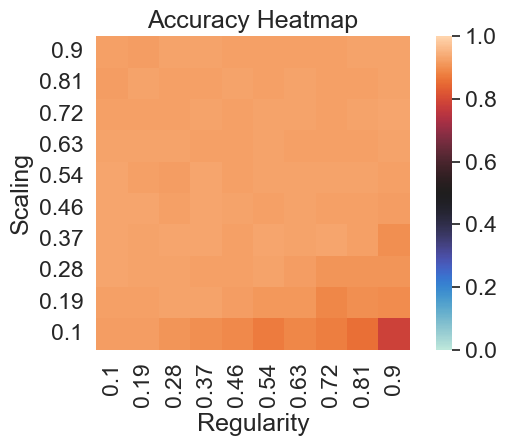

Total Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
Total Training Progress:   0%|          | 0/300 [00:06<?, ?it/s]


NameError: name 'exit' is not defined

In [26]:
import distutils.spawn
from typing import Optional

from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(font_scale=1.5)
if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

def plot_heatmap(results: list):
    """Plot heatmaps which describes the performance,
    as a function of scaling and initialization regularity.
    """

    df = pd.DataFrame.from_dict(results)

    df2 = pd.pivot_table(df, index='scaling', columns='regularity',
                         values='accuracy', aggfunc=np.max)
    df2.index = np.round(df2.index, 2)
    df2.columns = np.round(df2.columns, 2)

    sns.heatmap(df2[::-1], vmin=0, vmax=1, center=0.5, xticklabels=1,
                yticklabels=1, square=True)
    plt.title("Accuracy Heatmap")
    plt.xlabel("Regularity")
    plt.ylabel("Scaling")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    grid_lr = [0.001, 0.01, 0.1]
    grid_regularity = np.linspace(0.1, 0.9, 10)
    grid_scaling = np.linspace(0.1, 0.9, 10)
    exp_config = perf_weights_regularity

    for dataset in ['MNIST', 'CIFAR10']:
        exp_config['dataset'] = dataset
        fit_parallel(exp_config, grid_lr, grid_regularity, grid_scaling)
        exp_name = exp_config['name'].replace('dataset', dataset)
        results = get_results(exp_name)
        plot_heatmap(results)

In [27]:
from abc import ABC, abstractmethod

import numpy as np
import pytorch_lightning as pl
import torch
from torch import nn


def create_linear_layers_rbf(depth: int, width: int, regularity: float) -> nn.Sequential:
    mean = [0] * (depth + 1)
    gram = gram_matrix(depth, regularity)
    gp = np.random.default_rng().multivariate_normal(mean, gram, (width, width))
    increments = gp[:, :, 1:] - gp[:, :, :-1]
    weights = torch.Tensor(increments / (np.mean(np.std(increments, axis=(0, 1))) * np.sqrt(width)))
    layers = [nn.Linear(width, width, bias=False) for _ in range(depth)]
    for k in range(depth):
        layers[k].weight = torch.nn.Parameter(weights[:, :, k])
    return nn.Sequential(*layers)


def create_linear_layers_fbm(depth: int, width: int, hurst_index: float) -> nn.Sequential:
    weights = torch.zeros(depth, width, width)
    for i in range(width):
        for j in range(width):
            weights[:, i, j] = torch.Tensor(generate_fbm(depth, hurst_index)[1] / np.sqrt(width))
    layers = [nn.Linear(width, width) for _ in range(depth)]
    for k in range(depth):
        layers[k].weight = torch.nn.Parameter(weights[k])
        layers[k].bias = torch.nn.Parameter(torch.zeros(width,))
    return nn.Sequential(*layers)


def create_linear_layer(in_features: int, out_features: int, bias: bool = True) -> nn.Linear:
    layer = nn.Linear(in_features, out_features, bias=bias)
    length = torch.sqrt(torch.Tensor([3. / in_features]))
    layer.weight = nn.Parameter(2 * length * torch.rand((out_features, in_features)) - length)
    if bias:
        layer.bias = nn.Parameter(2 * length * torch.rand((out_features,)) - length)
    return layer


class ResNet(pl.LightningModule, ABC):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        super().__init__()
        self.initial_width = first_coord
        self.final_width = final_width
        self.model_config = model_config
        self.width = model_config['width']
        self.depth = model_config['depth']
        self.activation = getattr(nn, model_config['activation'])()

        self.scaling_weight = torch.full((self.depth,), 1 / (float(self.depth) ** model_config['scaling']))
        self.init = create_linear_layer(self.initial_width, self.width, bias=False)
        self.final = create_linear_layer(self.width, self.final_width, bias=False)
        self.loss = nn.CrossEntropyLoss()
        self.loss_history = []

    def reset_scaling(self, scaling: float):
        self.scaling_weight = torch.full((self.depth,), 1 / (float(self.depth) ** scaling))

    @abstractmethod
    def forward_hidden_state(self, hidden_state):
        ...

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hidden_state = self.init(x)
        hidden_state = self.forward_hidden_state(hidden_state)
        return self.final(hidden_state)

    def training_step(self, batch, batch_no):
        self.train()
        data, target = batch
        logits = self(data)
        loss = self.loss(logits, target)
        self.loss_history.append(loss.item())  # Track loss
        self.log("train/loss", loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.model_config['lr'])


class SimpleResNet(ResNet):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        super().__init__(first_coord, final_width, **model_config)

        if model_config['regularity']['type'] == 'iid':
            self.outer_weights = nn.Sequential(
                *[create_linear_layer(self.width, self.width, bias=False) for _ in range(self.depth)])
        elif model_config['regularity']['type'] == 'fbm':
            self.outer_weights = create_linear_layers_fbm(self.depth, self.width, model_config['regularity']['value'])
        elif model_config['regularity']['type'] == 'rbf':
            self.outer_weights = create_linear_layers_rbf(self.depth, self.width, model_config['regularity']['value'])
        else:
            raise ValueError("argument regularity['type'] should be one of 'iid', 'fbm', 'rbf'")

    def forward_hidden_state(self, hidden_state: torch.Tensor) -> torch.Tensor:
        for k in range(self.depth):
            pre_activation = hidden_state
            activated = self.activation(pre_activation)
            activated_derivative = 1.0 - activated**2  # tanh'
            correction_term = activated_derivative * activated
            hurst = self.model_config['regularity']['value']
            ch_scale = 1.0 / (2 * (self.depth ** (2 * hurst)))
            hidden_state = hidden_state + (
                self.scaling_weight[k] * self.outer_weights[k](activated)
            ) + ch_scale * correction_term
        return hidden_state


class FullResNet(ResNet):
    def __init__(self, first_coord: int, final_width: int, **model_config: dict):
        super().__init__(first_coord, final_width, **model_config)

        if model_config['regularity']['type'] == 'iid':
            self.inner_weights = nn.Sequential(
                *[create_linear_layer(self.width, self.width, bias=False) for _ in range(self.depth)])
            self.outer_weights = nn.Sequential(
                *[create_linear_layer(self.width, self.width, bias=False) for _ in range(self.depth)])
        elif model_config['regularity']['type'] == 'fbm':
            self.inner_weights = create_linear_layers_fbm(self.depth, self.width, model_config['regularity']['value'])
            self.outer_weights = create_linear_layers_fbm(self.depth, self.width, model_config['regularity']['value'])
        elif model_config['regularity']['type'] == 'rbf':
            self.inner_weights = create_linear_layers_rbf(self.depth, self.width, model_config['regularity']['value'])
            self.outer_weights = create_linear_layers_rbf(self.depth, self.width, model_config['regularity']['value'])
        else:
            raise ValueError("argument regularity['type'] should be one of 'iid', 'fbm', 'rbf'")

        self.final = create_linear_layer(self.width, self.final_width, bias=False)
        self.loss = nn.CrossEntropyLoss()

    def forward_hidden_state(self, hidden_state: torch.Tensor) -> torch.Tensor:
        for k in range(self.depth):
            pre_activation = self.inner_weights[k](hidden_state)
            activated = self.activation(pre_activation)
            activated_derivative = 1.0 - activated**2  # tanh'
            correction_term = activated_derivative * activated
            hurst = self.model_config['regularity']['value']
            ch_scale = 1.0 / (2 * (self.depth ** (2 * hurst)))
            hidden_state = hidden_state + (
                self.scaling_weight[k] * self.outer_weights[k](activated)
            ) + ch_scale * correction_term
        return hidden_state


Total Training Progress: 100%|██████████| 300/300 [40:45<00:00,  8.15s/it]
/var/folders/cx/4rt1cs1j0t9ffbyb2vdx8bv80000gn/T/ipykernel_39600/2002002190.py:22: FutureWarning: The provided callable <function max at 0x112fe8860> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df2 = pd.pivot_table(df, index='scaling', columns='regularity',


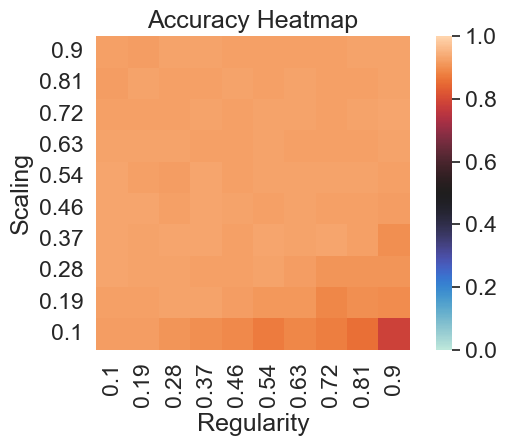

Total Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
Total Training Progress:   4%|▍         | 13/300 [02:04<45:44,  9.56s/it]


KeyboardInterrupt: 

In [28]:
import distutils.spawn
from typing import Optional

from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(font_scale=1.5)
if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

def plot_heatmap(results: list):
    """Plot heatmaps which describes the performance,
    as a function of scaling and initialization regularity.
    """

    df = pd.DataFrame.from_dict(results)

    df2 = pd.pivot_table(df, index='scaling', columns='regularity',
                         values='accuracy', aggfunc=np.max)
    df2.index = np.round(df2.index, 2)
    df2.columns = np.round(df2.columns, 2)

    sns.heatmap(df2[::-1], vmin=0, vmax=1, center=0.5, xticklabels=1,
                yticklabels=1, square=True)
    plt.title("Accuracy Heatmap")
    plt.xlabel("Regularity")
    plt.ylabel("Scaling")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    grid_lr = [0.001, 0.01, 0.1]
    grid_regularity = np.linspace(0.1, 0.9, 10)
    grid_scaling = np.linspace(0.1, 0.9, 10)
    exp_config = perf_weights_regularity

    for dataset in ['MNIST', 'CIFAR10']:
        exp_config['dataset'] = dataset
        fit_parallel(exp_config, grid_lr, grid_regularity, grid_scaling)
        exp_name = exp_config['name'].replace('dataset', dataset)
        results = get_results(exp_name)
        plot_heatmap(results)